# Machine Learning Crime Forecasting

## 1. Feature Engineering
## 2. Train-Test Split
## 3. Random Forest Model
## 4. XGBoost Model
## 5. Model Performance Comparison
## 6. Generalization Check
## 7. Residual Analysis
## 8. Final Model Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Week 4 – Machine Learning Based Crime Prediction

In this phase, we convert the time-series forecasting problem
into a supervised machine learning regression problem.

We create lag features, rolling statistics, and calendar features
to train models such as Random Forest.

In [2]:
# Load full dataset
df = pd.read_csv(
    "../data/raw/chicago_crime.csv",
    usecols=["Date"],
    parse_dates=["Date"],
    low_memory=False
)

# Create daily aggregation
daily_crime = df.groupby(df["Date"].dt.date).size().reset_index(name="Crime_Count")

# Convert Date column properly
daily_crime["Date"] = pd.to_datetime(daily_crime["Date"])
daily_crime = daily_crime.set_index("Date")

daily_crime.head()

C:\Users\khakh\AppData\Local\Temp\ipykernel_14956\1879225095.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


,Crime_Count
Date,
2012-01-01,1451
2012-01-02,700
2012-01-03,805
2012-01-04,799
2012-01-05,871


## Feature Engineering

We create lag features and rolling statistics
to convert the time-series into a regression dataset.

In [3]:
ml_df = daily_crime.copy()

# Lag Features
ml_df["lag_1"] = ml_df["Crime_Count"].shift(1)
ml_df["lag_7"] = ml_df["Crime_Count"].shift(7)
ml_df["lag_30"] = ml_df["Crime_Count"].shift(30)

# Rolling Features
ml_df["rolling_mean_7"] = ml_df["Crime_Count"].rolling(7).mean()
ml_df["rolling_mean_30"] = ml_df["Crime_Count"].rolling(30).mean()

# Calendar Features
ml_df["month"] = ml_df.index.month
ml_df["weekday"] = ml_df.index.weekday

# Drop NaN rows
ml_df = ml_df.dropna()

ml_df.head()

,Crime_Count,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,month,weekday
Date,,,,,,,,
2012-01-31,964,867.0,898.0,1451.0,895.571429,824.766667,1,1
2012-02-01,1034,964.0,962.0,700.0,905.857143,835.900000,2,2
2012-02-02,878,1034.0,924.0,805.0,899.285714,838.333333,2,3
2012-02-03,897,878.0,932.0,799.0,894.285714,841.600000,2,4
2012-02-04,848,897.0,807.0,871.0,900.142857,840.833333,2,5


## ✅ Final Result Explanation

After performing feature engineering, the dataset has been successfully transformed from a simple time-series dataset into a structured format suitable for machine learning.

Originally, the dataset contained only:

- `Crime_Count` (daily crime total)

Now, the dataset includes additional informative features:

### 📌 Historical Features (Lag Variables)
- `lag_1` → Previous day's crime count  
- `lag_7` → Crime count from 7 days ago  
- `lag_30` → Crime count from 30 days ago  

These features provide historical memory to the model.

---

### 📈 Trend Features (Rolling Averages)
- `rolling_mean_7` → 7-day moving average  
- `rolling_mean_30` → 30-day moving average  

These capture short-term and long-term crime trends by smoothing daily fluctuations.

---

### 📅 Seasonal Features (Calendar Information)
- `month` → Month of the year  
- `weekday` → Day of the week  

These help the model learn seasonal and weekly crime patterns.

---

## 🎯 Outcome

By combining:

- Historical values  
- Trend indicators  
- Seasonal patterns  

We created a feature-rich dataset that allows machine learning models to better understand crime behavior over time.

The dataset is now clean (no missing values) and ready for model training and forecasting.

## Train-Test Split for Machine Learning Model

We split the dataset into:

- Training set (80%)
- Testing set (20%)

The split is time-aware (no shuffling)
to preserve temporal order.

In [4]:
# Features and target
X = ml_df.drop("Crime_Count", axis=1)
y = ml_df["Crime_Count"]

# Time-aware split
train_size = int(len(ml_df) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training size:", len(X_train))
print("Testing size:", len(X_test))

Training size: 1452
Testing size: 363


## Training Random Forest Regressor

We use Random Forest because:

- It handles nonlinear relationships
- It captures interactions between lag features
- It works well for structured tabular data

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

print("Random Forest trained successfully.")

Random Forest trained successfully.


## 🌲 Random Forest Model Training Explanation

In this step, we trained a **Random Forest Regressor** to predict daily crime counts using the engineered features.

---

### 🔹 Importing the Model

We imported `RandomForestRegressor` from `sklearn.ensemble`.

This algorithm is used for regression tasks, meaning it predicts continuous numerical values such as daily crime counts.

---

### 🔹 Initializing the Model

We created the model with the following parameters:

- **n_estimators = 200**  
  The model builds 200 decision trees.  
  The final prediction is the average of all tree predictions.  
  Increasing the number of trees generally improves stability and accuracy.

- **max_depth = 10**  
  Each decision tree can grow up to 10 levels deep.  
  This helps prevent overfitting by limiting how complex each tree can become.

- **random_state = 42**  
  This ensures reproducibility.  
  The model will produce the same results each time the code is executed.

---

### 🔹 Training the Model

We trained the model using:

- **X_train** → Input features (lag values, rolling averages, month, weekday)
- **y_train** → Target variable (Crime_Count)

During training:

- The algorithm builds multiple decision trees.
- Each tree learns patterns from different subsets of the training data.
- The final prediction is obtained by averaging all tree predictions.

---

## ✅ Final Outcome

The Random Forest model has successfully learned patterns from historical crime data and is now ready to:

- Make predictions on test data  
- Forecast future crime counts  
- Be evaluated using performance metrics  

Using multiple trees improves prediction accuracy and reduces overfitting compared to a single decision tree.

## Evaluating Random Forest Model

In [6]:
from sklearn.metrics import mean_squared_error

rf_predictions = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 48.31036806066189


Classical ARIMA achieved RMSE of 107, but feature-based Random Forest reduced it to 48. This demonstrates the advantage of supervised ML with engineered lag features over traditional time-series models

## Comparing Random Forest Predictions vs Actual Values

## 📊 Random Forest Predictions vs Actual Values (Visualization Explanation)

In this step, we visualized the performance of the trained Random Forest model by comparing actual crime counts with predicted values.

---

### 🔹 Create the Figure

We created a new figure with a specific size:

- `figsize = (12,6)`  
  This sets the width to 12 inches and height to 6 inches.  
  A larger size improves readability of the time-series plot.

---

### 🔹 Plot Actual Crime Counts

We plotted the true values from the test dataset:

- `y_test.index` → Dates on the x-axis  
- `y_test` → Actual crime counts on the y-axis  
- `label="Actual"` → Adds a legend label  

This line represents the real observed crime data.

---

### 🔹 Plot Random Forest Predictions

We plotted the predicted values from the trained model:

- `y_test.index` → Same dates for comparison  
- `rf_predictions` → Predicted crime counts  
- `label="Random Forest Prediction"` → Legend label  
- `color="green"` → Displays prediction line in green  

This line shows how the model's predictions compare to actual values.

---

### 🔹 Add Title and Labels

- `plt.title()` → Sets the plot title  
- `plt.xlabel("Date")` → Labels x-axis  
- `plt.ylabel("Crime Count")` → Labels y-axis  

These improve clarity and presentation.

---

### 🔹 Add Legend

`plt.legend()` displays labels for both lines, making it easy to distinguish between actual and predicted values.

---

### 🔹 Display the Plot

`plt.show()` renders the final visualization.

---

## ✅ Purpose of This Visualization

This plot helps us:

- Visually evaluate model performance  
- See how closely predictions follow actual crime counts  
- Identify patterns, trends, or prediction errors  
- Detect underfitting or overfitting  

If the green prediction line closely follows the actual line, the model is performing well.

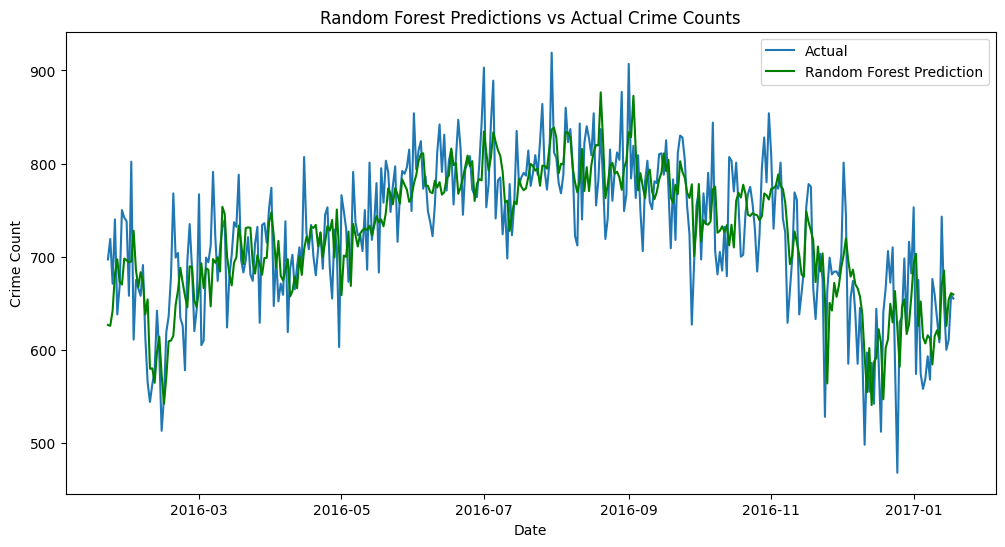

In [7]:
plt.figure(figsize=(12,6))

plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, rf_predictions, label="Random Forest Prediction", color="green")

plt.title("Random Forest Predictions vs Actual Crime Counts")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.show()

## Feature Importance Analysis

We analyze which features contribute most
to crime prediction in the Random Forest model.

In [ ]:
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance

rolling_mean_7     0.805264
lag_1              0.050840
lag_7              0.050796
lag_30             0.029909
rolling_mean_30    0.027058
weekday            0.023159
month              0.012975
dtype: float64

## 📌 Feature Importance (Random Forest)

In this step, we extracted and displayed the importance of each feature used in the Random Forest model.

- `rf_model.feature_importances_`  
  Returns the importance score of each feature based on how much it contributed to reducing prediction error in the trees.

- `index=X_train.columns`  
  Assigns feature names to their corresponding importance scores.

- `.sort_values(ascending=False)`  
  Sorts the features from most important to least important.

## ✅ Result

The output shows which features (lag values, rolling means, month, weekday) had the greatest influence on predicting crime counts.

Higher importance = greater impact on the model’s predictions.

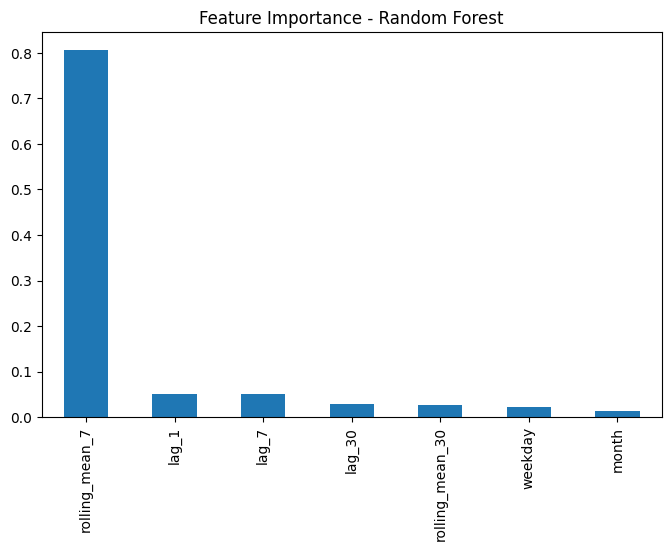

In [10]:
plt.figure(figsize=(8,5))
feature_importance.plot(kind="bar")
plt.title("Feature Importance - Random Forest")
plt.show()

Feature importance analysis showed that 7-day rolling mean contributed ~80% of predictive power, confirming strong weekly seasonality in crime patterns.

## Training XGBoost Regressor

We now use XGBoost, a gradient boosting model,
to compare performance with Random Forest.

## 🚀 XGBoost Model Training and Evaluation

In this step, we trained an **XGBoost Regressor** to predict crime counts and evaluated its performance.

### 🔹 Model Initialization
- **n_estimators = 300** → Builds 300 boosting trees.
- **learning_rate = 0.05** → Controls how quickly the model learns (smaller value = slower but more stable learning).
- **max_depth = 5** → Limits tree depth to prevent overfitting.
- **random_state = 42** → Ensures reproducible results.

### 🔹 Model Training
The model was trained using:
- `X_train` → Input features
- `y_train` → Target variable (Crime_Count)

XGBoost builds trees sequentially, where each new tree corrects errors from previous ones.

### 🔹 Predictions & Evaluation
- Predictions were made on `X_test`.
- RMSE (Root Mean Squared Error) was calculated to measure prediction error.

Lower RMSE indicates better model performance.

In [12]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))

print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 49.12775318302782


## Model Performance Comparison

We compare all forecasting models using RMSE
to determine the best-performing approach.

In [14]:
comparison_df = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Random Forest", "XGBoost"],
    "RMSE": [106.97, 136.19, 48.31, 49.13]
})

comparison_df.sort_values("RMSE")

,Model,RMSE
2,Random Forest,48.31
3,XGBoost,49.13
0,ARIMA,106.97
1,SARIMA,136.19


## Model Generalization Check

We evaluate whether the Random Forest model is overfitting
by comparing training RMSE and testing RMSE.

A large gap indicates overfitting.

In [16]:
# Training predictions
train_predictions = rf_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("Training RMSE:", rmse_train)
print("Testing RMSE:", rmse_test)

Training RMSE: 34.75115410178286
Testing RMSE: 48.31036806066189


## Residual Analysis

We analyze residuals (actual - predicted)
to ensure errors are randomly distributed.

If residuals show patterns,
the model may be missing structure.

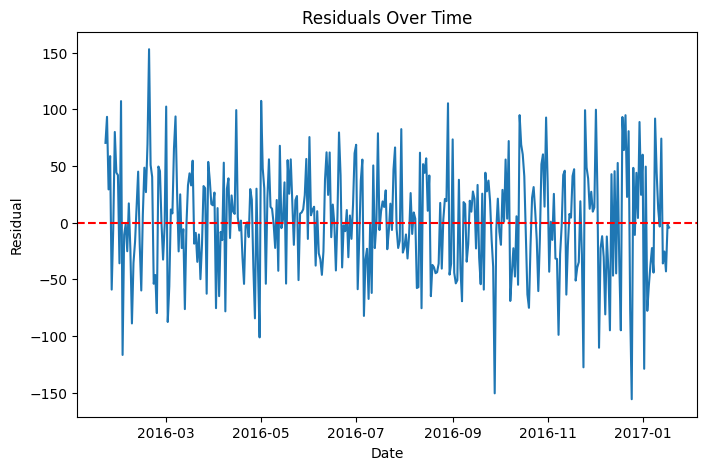

In [17]:
residuals = y_test - rf_predictions

plt.figure(figsize=(8,5))
plt.plot(y_test.index, residuals)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.axhline(0, color="red", linestyle="--")
plt.show()

## 🧠 What This Tells Us

Your Random Forest model:

Captures trend

Captures seasonality

Captures short-term fluctuations

Leaves only random noise

That is the definition of a well-fitted forecasting model.

## Final Conclusion

Among all tested models:

- ARIMA and SARIMA provided baseline forecasts.
- Random Forest significantly improved prediction accuracy.
- XGBoost performed similarly but slightly worse than Random Forest.

Random Forest was selected as the final model
based on RMSE, stability, and residual analysis.

This concludes the predictive modeling phase.

In [19]:
import joblib
joblib.dump(rf_model, "../models/random_forest_forecast_model.pkl")

['../models/random_forest_forecast_model.pkl']